**IMPORTING DEPENDENCIES**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

In [2]:
class_names=['Gun','Knife','Money','Phone']
class_names_label= {class_name:i for i,class_name in enumerate(class_names)}

nb_classes=len(class_names)

print(class_names_label)

IMAGE_SIZE=(150,150)

{'Gun': 0, 'Knife': 1, 'Money': 2, 'Phone': 3}


In [3]:
def load_data():
    DIRECTORY=r"C:\Misc"
    CATEGORY= ["Seg_train","Seg_test"]
    
    output=[]
    
    for category in CATEGORY:
        path=os.path.join(DIRECTORY, category)
        images=[]
        labels=[]
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label=class_names_label[folder]
            
            for file in os.listdir(os.path.join(path,folder)):
                
                img_path=os.path.join(os.path.join(path,folder),file)
                
                image=cv2.imread(img_path)
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image=cv2.resize(image,IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
                
        images=np.array(images,dtype='float32')
        labels=np.array(labels,dtype='int32')
        
        output.append((images,labels))
        
    return output

In [4]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Loading Seg_train
Loading Seg_test


In [5]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=25)

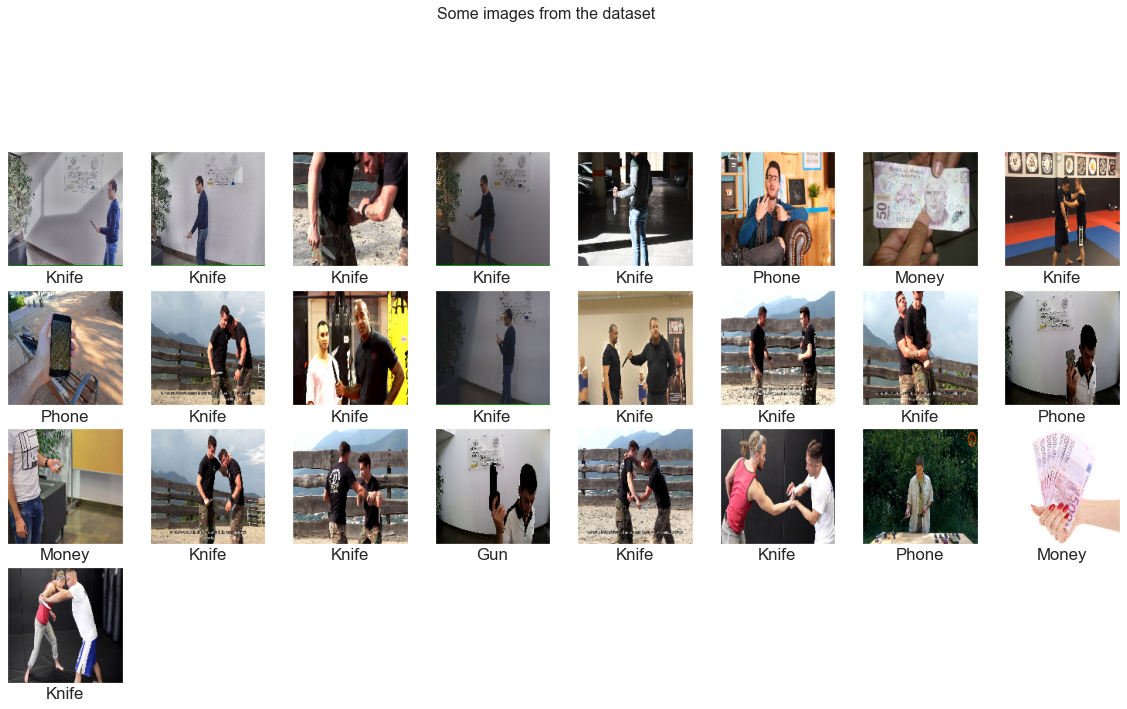

In [6]:
def display_examples(class_names,images,labels):
    
    figsize=(20,20)
    fig= plt.figure(figsize=figsize)
    fig.suptitle("Some images from the dataset",fontsize=16)
    
    for i in range(25):
        plt.subplot(8,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
        
    plt.show()
display_examples(class_names,train_images,train_labels)

**CREATING AND TRAINING A KERAS MODEL**

In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(150, 150, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
        )
    return model

In [8]:
# Instantiating the model
model = create_model()

# Training the model
model.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)

Train on 1204 samples
Epoch 1/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 480.6406 - accuracy: 0.2467
Epoch 2/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 72.5135 - accuracy: 0.6487
Epoch 3/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 3.8210 - accuracy: 0.6063
Epoch 4/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.7612 - accuracy: 0.7766
Epoch 5/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.4108 - accuracy: 0.8796
Epoch 6/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.1920 - accuracy: 0.9336
Epoch 7/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.0973 - accuracy: 0.9709
Epoch 8/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.0623 - accuracy: 0.9826
Epoch 9/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.0296 - accuracy: 0.9925
Epoch 10/10
1204/1204 [================

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


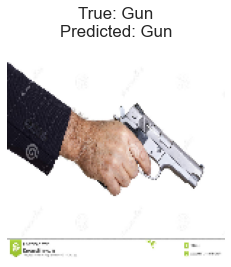

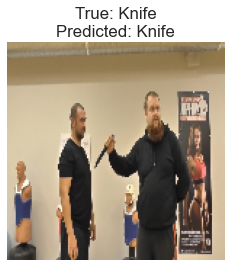

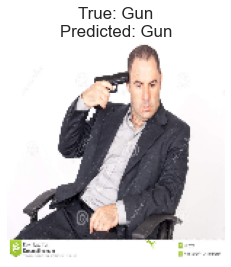

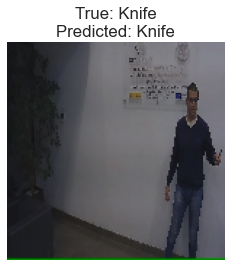

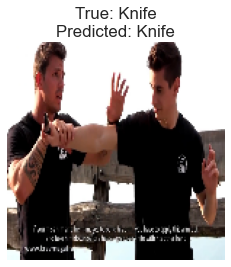

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Function to convert numerical labels back to class names (if applicable)
def get_class_name(label):
    # Define your class names or labels
    class_names = ['Gun', 'Knife', 'Money', 'Phone']  # Replace with your actual class names
    return class_names[label]

# Randomly select a few images from the test set
num_images = 5  # Number of images to visualize
indices = np.random.randint(0, len(test_images), num_images)

# Visualize the images and their predictions
for idx in indices:
    image = test_images[idx]
    label = test_labels[idx]
    
    # Make predictions on the image
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(prediction)
    
    # Convert labels to class names
    true_class = get_class_name(label)
    predicted_class = get_class_name(predicted_label)
    
    # Plot the image with its true and predicted labels
    normalized_image= image/255.0
    plt.imshow(normalized_image)
    plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
    plt.axis('off')
    plt.show()


# **EVASION ATTACK**

For running evasion attacks on the model, it should be wrapped in the art.estimators.classification.KerasClassifier class.

***Defining the attack using FastGradientMethod class***
*The fast gradient method applies noise to clean test images.*

In [10]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model,              # indicates our model
    clip_values=(0, 255)    # minimum and maximum values allowed for features
    )

In [11]:
attack_fgsm = FastGradientMethod(
    estimator=classifier,            # attack will apply to our classifier
    eps=0.9                        # defines the strength of the attack
    )

***Generating adversarial samples***

In [12]:
test_images_adv = attack_fgsm.generate(x=test_images)

In [13]:
min_value = np.amin(test_images_adv)
max_value = np.amax(test_images_adv)

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 0.0
Maximum value: 255.0


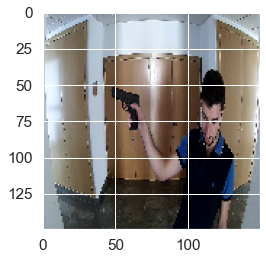

In [14]:
# Viewing an adversarial image
# Assuming test_images_adv[0] is your image data
normalized_image = test_images_adv[0] / 255.0

plt.imshow(normalized_image)
plt.show()

***Assessing the effect of the attack***

In [15]:
# Testing the model for clean images
score_clean = model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Testing the model for adversarial images
score_adv = model.evaluate(
    x=test_images_adv, 
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.01 vs adversarial set test loss: 1.31
Clean test set accuracy: 1.00 vs adversarial test set accuracy: 0.65


***Testing the accuracy for each eps value***

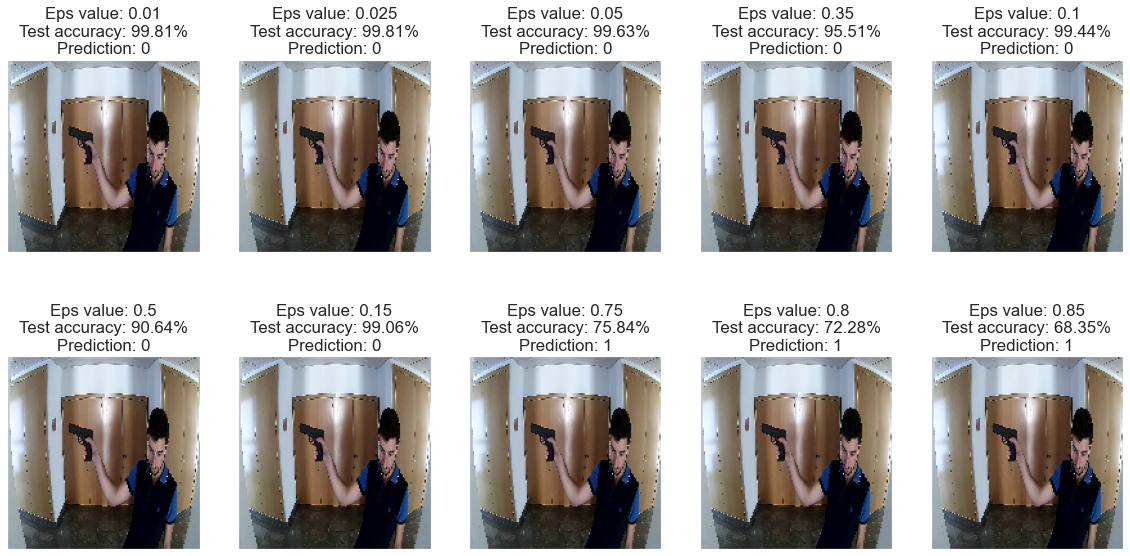

In [16]:
# Number of rows and columns for the figure
nrows, ncols = 2, 5

# Subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )


# Range of eps values
eps_to_try = [0.01, 0.025, 0.05, 0.35, 0.1, 0.50, 0.15, 0.75, 0.8, 0.85]
counter = 0

for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object  
        attack_fgsm = FastGradientMethod(
            estimator=classifier, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=normalized_image)

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv, 
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )
        counter += 1
plt.show()

# **EXTRACTION ATTACKS**

***Implementing CopycatCNN***

In [17]:
artclassifier2 = KerasClassifier(model=model, clip_values=(0, 255), use_logits=False)

In [18]:
from art.attacks.extraction import CopycatCNN
cc_attack = CopycatCNN(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [19]:
def train_percentage(n):
   
    num_imgs = train_images.shape[ 0 ]
    num_poisoned_images = n
    print( 'Percentage of access to train images', num_poisoned_images*100 / num_imgs )
    idx = np.arange( num_imgs, dtype=np.int )
    np.random.shuffle( idx )
    candidate_images = np.copy( train_images[ idx[ :num_poisoned_images ] ] )
    target_labels=np.copy( train_labels[ idx[ :num_poisoned_images ] ] )
    return candidate_images,target_labels

***With 5% data access***

In [20]:
x_extr,y_extr = train_percentage(61)

Percentage of access to train images 5.0664451827242525


C:\Users\sihus\AppData\Local\Temp\ipykernel_22376\3038952397.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.arange( num_imgs, dtype=np.int )


In [21]:
stolen_classifier = cc_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

Train on 61 samples
Epoch 1/5
61/61 [==============================] - 0s 8ms/sample - loss: 0.1211 - accuracy: 0.9508
Epoch 2/5
61/61 [==============================] - 0s 8ms/sample - loss: 0.2080 - accuracy: 0.9672
Epoch 3/5
61/61 [==============================] - 0s 8ms/sample - loss: 0.6330 - accuracy: 0.9016
Epoch 4/5
61/61 [==============================] - 1s 10ms/sample - loss: 0.3307 - accuracy: 0.9344
Epoch 5/5
61/61 [==============================] - 1s 10ms/sample - loss: 0.1883 - accuracy: 1.0000


In [22]:
stolen_classifier._model.evaluate(test_images,test_labels)

[0.5417910892776238, 0.8913858]

***With 10% data access***

In [23]:
from art.attacks.extraction import CopycatCNN
cc_attack = CopycatCNN(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [24]:
x_extr,y_extr = train_percentage(121)

Percentage of access to train images 10.049833887043189


C:\Users\sihus\AppData\Local\Temp\ipykernel_22376\3038952397.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.arange( num_imgs, dtype=np.int )


In [25]:
stolen_classifier = cc_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 1s 8ms/sample - loss: 0.2120 - accuracy: 0.9500
Epoch 2/5
100/100 [==============================] - 1s 9ms/sample - loss: 0.0371 - accuracy: 1.0000
Epoch 3/5
100/100 [==============================] - 1s 10ms/sample - loss: 0.3057 - accuracy: 0.9200
Epoch 4/5
100/100 [==============================] - 1s 10ms/sample - loss: 0.3806 - accuracy: 0.9400
Epoch 5/5
100/100 [==============================] - 1s 10ms/sample - loss: 0.3682 - accuracy: 0.9400


In [26]:
stolen_classifier._model.evaluate(test_images,test_labels)

[0.9938716844198633, 0.7827715]

***With 30% data access***

In [27]:
from art.attacks.extraction import CopycatCNN
cc_attack = CopycatCNN(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [28]:
x_extr,y_extr = train_percentage(370)

Percentage of access to train images 30.730897009966778


C:\Users\sihus\AppData\Local\Temp\ipykernel_22376\3038952397.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.arange( num_imgs, dtype=np.int )


In [29]:
stolen_classifier = cc_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 1s 9ms/sample - loss: 0.4358 - accuracy: 0.9200
Epoch 2/5
100/100 [==============================] - 1s 10ms/sample - loss: 0.6487 - accuracy: 0.9100
Epoch 3/5
100/100 [==============================] - 1s 10ms/sample - loss: 0.1465 - accuracy: 0.9700
Epoch 4/5
100/100 [==============================] - 1s 9ms/sample - loss: 0.0878 - accuracy: 0.9800
Epoch 5/5
100/100 [==============================] - 1s 10ms/sample - loss: 0.0489 - accuracy: 1.0000


In [30]:
stolen_classifier._model.evaluate(test_images,test_labels)

[3.0789692008427942, 0.67790264]

***Implementing Knockoff Nets***

***With 5% data access***

In [31]:
from art.attacks.extraction import KnockoffNets
ko_attack = KnockoffNets(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [32]:
x_extr,y_extr = train_percentage(61)

Percentage of access to train images 5.0664451827242525


C:\Users\sihus\AppData\Local\Temp\ipykernel_22376\3038952397.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.arange( num_imgs, dtype=np.int )


In [33]:
stolen_classifier = ko_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

In [34]:
stolen_classifier._model.evaluate(test_images,test_labels)

[3.4825897819244256, 0.65917605]

***With 10% data access***

In [35]:
from art.attacks.extraction import KnockoffNets
ko_attack = KnockoffNets(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [36]:
x_exc,y_exc = train_percentage(121)

Percentage of access to train images 10.049833887043189


C:\Users\sihus\AppData\Local\Temp\ipykernel_22376\3038952397.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.arange( num_imgs, dtype=np.int )


In [37]:
stolen_classifier = ko_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

In [38]:
stolen_classifier._model.evaluate(test_images,test_labels)

[3.6970696529601996, 0.66292137]

***With 30% data access***

In [39]:
from art.attacks.extraction import KnockoffNets
ko_attack = KnockoffNets(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [40]:
x_extr, y_extr = train_percentage(370)

Percentage of access to train images 30.730897009966778


C:\Users\sihus\AppData\Local\Temp\ipykernel_22376\3038952397.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.arange( num_imgs, dtype=np.int )


In [41]:
stolen_classifier = ko_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

In [42]:
stolen_classifier._model.evaluate(test_images,test_labels)

[2.2255074835808824, 0.6966292]

# WHITE BOX ATTACKS

In [43]:
print(test_labels.shape)

(534,)


In [44]:
import numpy as np

def candidate_data(test_images, test_labels, n):
    cx_test = []
    cy_test = []

    unique_classes = np.unique(test_labels)  # Get the unique classes in y_test
    
    for class_label in unique_classes:
        indices = np.where(test_labels == class_label)[0]  # Find indices where class_label occurs
        selected_indices = indices[:n]  # Select the first n indices

        cx_test.append(test_images[selected_indices].copy())
        cy_test.append(test_labels[selected_indices].copy())

    cx_test = np.concatenate(cx_test)
    cy_test = np.concatenate(cy_test)

    return cx_test, cy_test


(100, 150, 150, 3)
(100,)
class 0


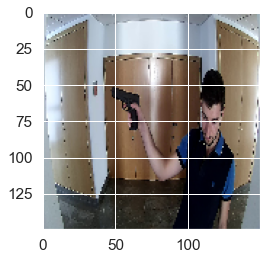

In [45]:
# testing the sampling function

sample_test, sample_label=candidate_data(test_images, test_labels, 25)

# print(adv_test[0])
print(sample_test.shape)
print(sample_label.shape)


print("class {}".format(np.argmax(sample_label[80])))


normalized_image = sample_test[0] / 255.0
plt.imshow(normalized_image)
plt.show()


In [46]:
model.evaluate(test_images,test_labels)

[2.2255074835808824, 0.6966292]

In [47]:
from art.estimators.classification import TensorFlowV2Classifier

In [48]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier = KerasClassifier(model=model, 
                                    clip_values=(0, 255), channels_first=False)

In [49]:
#artclassifier2 = KerasClassifier(model=model, clip_values=(0, 255), use_logits=False)

In [50]:
def implement_attack(model, attack, sample_test, test_labels, attack_name):
    # Generate the adversarial examples
    x_test_adv = attack.generate(sample_test)
    performance_metrics = model.evaluate(x_test_adv, test_labels)
    predictions = model.predict(x_test_adv)

    # Convert 1-dimensional arrays to 2-dimensional
    if len(test_labels.shape) == 1:
        test_labels = np.expand_dims(test_labels, axis=1)
    if len(predictions.shape) == 1:
        predictions = np.expand_dims(predictions, axis=1)

    report = classification_report(
        np.argmax(test_labels, axis=1),
        np.argmax(predictions, axis=1),
        output_dict=True
    )

    report = report['weighted avg']
    report.update({'Loss': performance_metrics[0]})
    report.update({'Accuracy': performance_metrics[1]})
    report.update({'Attack': attack_name})

    return report, x_test_adv, predictions


**NEWTONFOOL ATTACK**

In [51]:
from art.attacks.evasion import NewtonFool

In [52]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [53]:
attack_newt = NewtonFool(classifier=artclassifier, max_iter=10, batch_size=20,eta=0.01)

In [54]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_newt, sample_test=sample_test, test_labels=sample_label, attack_name='Newton fool attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

NewtonFool:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Adverserial test image
predicted label: 0


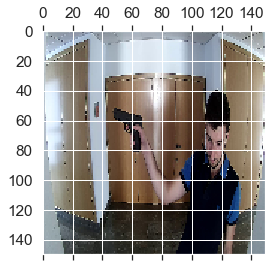

In [55]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()

**DEEPFOOL ATTACK**

In [93]:
from art.attacks.evasion import DeepFool

In [94]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [95]:
attack_deepf = DeepFool(classifier=artclassifier, max_iter=10, batch_size=20,epsilon=0.01)

In [96]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_deepf, sample_test=sample_test, test_labels=sample_label, attack_name='Deepfool attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

DeepFool:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual test image
Label: 0


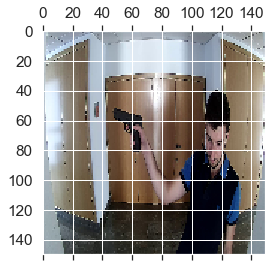

In [101]:
print("Actual test image")
print("Label: {}".format(np.argmax(sample_label[0])))

normalized_image = sample_test[0] / 255.0
plt.matshow(normalized_image)
plt.show()

Adverserial test image
predicted label: 1


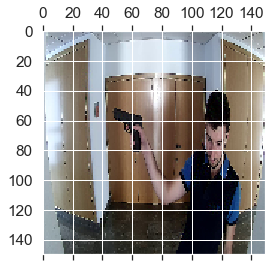

In [102]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()

**JACOBIAN SALIENCY MAP ATTACK**

In [106]:
from art.attacks.evasion import SaliencyMapMethod

In [107]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [110]:
attack_jsm = SaliencyMapMethod(artclassifier, theta=0.1, gamma=1.0, batch_size=50)

Actual test image
Label: 0


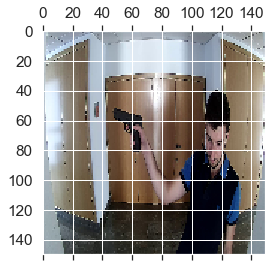

In [112]:
print("Actual test image")
print("Label: {}".format(np.argmax(sample_label[0])))

normalized_image = sample_test[0] / 255.0
plt.matshow(normalized_image)
plt.show()

Adverserial test image
predicted label: 1


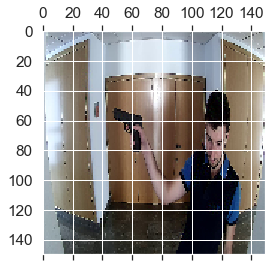

In [113]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()

**PROJECTED GRADIENT DESCENT ATTACK**

In [71]:
from art.attacks.evasion import ProjectedGradientDescent

In [72]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [73]:
attack_pgd = ProjectedGradientDescent(estimator=artclassifier, max_iter=10, eps=0.01, eps_step=0.001, targeted=False)

In [74]:
report, x_test_adv, predictions = implement_attack(model, attack_pgd, sample_test=sample_test, test_labels=sample_label, attack_name='Projected Gradient Descent attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual test image
Label: 0


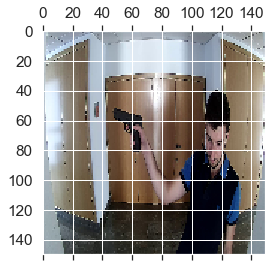

In [75]:
print("Actual test image")
print("Label: {}".format(np.argmax(sample_label[0])))

normalized_image = sample_test[0] / 255.0
plt.matshow(normalized_image)
plt.show()

Adverserial test image
predicted label: 0


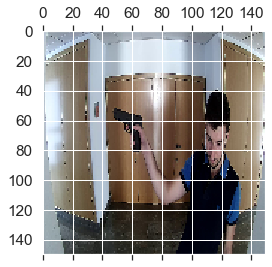

In [76]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()

# BLACK BOX ATTACKS

**HOPSKIPJUMP ATTACK**

In [77]:
from art.attacks.evasion import HopSkipJump

In [78]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [79]:
attack_hpskp = HopSkipJump(classifier=artclassifier, batch_size=20, max_iter=10 ,max_eval=10000, init_eval=10, targeted=False)

In [80]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_hpskp, sample_test=sample_test, test_labels=sample_label, attack_name='Hop skip jump attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

HopSkipJump:   0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual test image
Label: 0


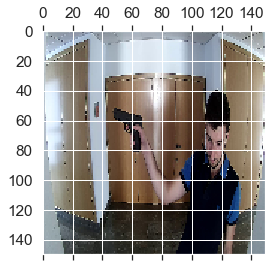

In [81]:
print("Actual test image")
print("Label: {}".format(np.argmax(sample_label[0])))

normalized_image = sample_test[0] / 255.0
plt.matshow(normalized_image)
plt.show()

Adverserial test image
predicted label: 1


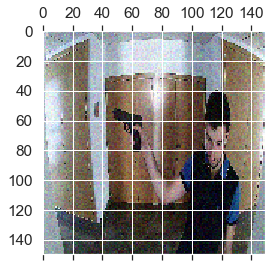

In [82]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()

**SPATIAL TRANSFORMATION ATTACK**

In [87]:
from art.attacks.evasion import SpatialTransformation

In [88]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [89]:
attack_spat = SpatialTransformation(artclassifier, num_translations=2, max_rotation=10, max_translation=15)

In [90]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_spat, sample_test=sample_test, test_labels=sample_label, attack_name='Spatial transformation attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

Spatial transformation:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_cla

Actual test image
Label: 0


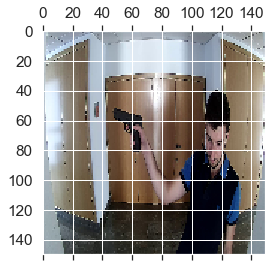

In [91]:
print("Actual test image")
print("Label: {}".format(np.argmax(sample_label[0])))

normalized_image = sample_test[0] / 255.0
plt.matshow(normalized_image)
plt.show()

Adverserial test image
predicted label: 2


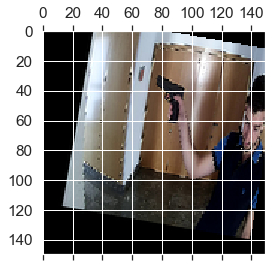

In [92]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()

# ADVERSARIAL DEFENCES

**CLASS LABELS**

In [156]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

In [163]:
def create_model():
    modelx = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(150, 150, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    modelx.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
        )
    return modelx

In [164]:
# Instantiating the model
modelx = create_model()

# Training the model
modelx.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)

Train on 1204 samples
Epoch 1/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 417.5026 - accuracy: 0.3322
Epoch 2/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 129.0516 - accuracy: 0.5855
Epoch 3/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 5.0852 - accuracy: 0.6154
Epoch 4/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.7480 - accuracy: 0.8331
Epoch 5/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.2989 - accuracy: 0.9103
Epoch 6/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.1536 - accuracy: 0.9576
Epoch 7/10
1204/1204 [==============================] - 9s 7ms/sample - loss: 0.0669 - accuracy: 0.9776
Epoch 8/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.0283 - accuracy: 0.9925
Epoch 9/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.0208 - accuracy: 0.9942
Epoch 10/10
1204/1204 [===============

In [167]:
artclassifierx = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(150, 150, 3), loss_object=model.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

In [168]:
classlabel_def(artclassifierx._model.predict(sample_test[1].reshape(1,150,150,3))), sample_label[1]

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), 0)

In [173]:
# evaluating the attack samples
perf =  artclassifierx._model.evaluate( x_test_adv, sample_label )
print( 'Loss and accuracy of adversarial examples: ', perf )

Loss and accuracy of adversarial examples:  [3.0503085613250733, 0.675]


**GAUSSIAN NOISE**

In [170]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

In [171]:
def create_model():
    modelx = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(150, 150, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    modelx.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
        )
    return modelx

In [187]:
# Instantiating the model
modelx = create_model()

# Training the model
modelx.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)

Train on 1204 samples
Epoch 1/10
1204/1204 [==============================] - 8s 6ms/sample - loss: 383.0127 - accuracy: 0.2409
Epoch 2/10
1204/1204 [==============================] - 9s 7ms/sample - loss: 123.1023 - accuracy: 0.6487
Epoch 3/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 5.9050 - accuracy: 0.6819
Epoch 4/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 1.5368 - accuracy: 0.6163
Epoch 5/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.6562 - accuracy: 0.7841
Epoch 6/10
1204/1204 [==============================] - 9s 7ms/sample - loss: 0.3393 - accuracy: 0.8995
Epoch 7/10
1204/1204 [==============================] - 8s 6ms/sample - loss: 0.1497 - accuracy: 0.9510
Epoch 8/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.1148 - accuracy: 0.9593
Epoch 9/10
1204/1204 [==============================] - 8s 6ms/sample - loss: 0.0483 - accuracy: 0.9850
Epoch 10/10
1204/1204 [===============

In [188]:
artclassifierx = TensorFlowV2Classifier(model=modelx, nb_classes=10, input_shape=(150, 150, 3), loss_object=modelx.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

In [189]:
gaussn_def(artclassifierx._model.predict(sample_test[1].reshape(1,150,150,3))), sample_label[1]

(array([[0.44702017, 0.1004495 , 0.06427958, 0.09525853, 0.        ,
         0.        , 0.10949304, 0.12539251, 0.        , 0.05810668]],
       dtype=float32),
 0)

In [190]:
# evaluating the attack samples
perf =  artclassifierx._model.evaluate( x_test_adv, sample_label )
print( 'Loss and accuracy of adversarial examples: ', perf )

Loss and accuracy of adversarial examples:  [10.783588409423828, 0.725]


**HIGH CONFIDENCE**

In [184]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

In [185]:
def create_model():
    modelx = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(150, 150, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    modelx.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
        )
    return modelx

In [186]:
# Instantiating the model
modelx = create_model()

# Training the model
modelx.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)

Train on 1204 samples
Epoch 1/10
1204/1204 [==============================] - 8s 6ms/sample - loss: 397.5031 - accuracy: 0.2998
Epoch 2/10
1204/1204 [==============================] - 8s 6ms/sample - loss: 84.3168 - accuracy: 0.6487
Epoch 3/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 2.8751 - accuracy: 0.6827
Epoch 4/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.8921 - accuracy: 0.8007
Epoch 5/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.5411 - accuracy: 0.8497
Epoch 6/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.3483 - accuracy: 0.8821
Epoch 7/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.2257 - accuracy: 0.9344
Epoch 8/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.1442 - accuracy: 0.9568
Epoch 9/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.0643 - accuracy: 0.9809
Epoch 10/10
1204/1204 [================

In [191]:
artclassifierx = TensorFlowV2Classifier(model=modelx, nb_classes=10, input_shape=(150, 150, 3), loss_object=modelx.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

In [193]:
hc_def(artclassifier._model.predict(sample_test[1].reshape(1,150,150,3))), sample_label[1]

(array([[0.999941, 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ]], dtype=float32),
 0)

In [194]:
# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'Loss and accuracy of adversarial examples: ', perf )

Loss and accuracy of adversarial examples:  [3.981657314300537, 0.525]


**REVERSE SIGMOID**

In [195]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

In [196]:
def create_model():
    modelx = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(150, 150, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softmax")
    ])

    modelx.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
        )
    return modelx

In [197]:
# Instantiating the model
modelx = create_model()

# Training the model
modelx.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10,
    batch_size=256)

Train on 1204 samples
Epoch 1/10
1204/1204 [==============================] - 8s 6ms/sample - loss: 368.0114 - accuracy: 0.2807
Epoch 2/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 145.8846 - accuracy: 0.6487
Epoch 3/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 15.5654 - accuracy: 0.6005
Epoch 4/10
1204/1204 [==============================] - 8s 6ms/sample - loss: 0.8090 - accuracy: 0.7334
Epoch 5/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.5447 - accuracy: 0.8422
Epoch 6/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.2410 - accuracy: 0.9070
Epoch 7/10
1204/1204 [==============================] - 7s 6ms/sample - loss: 0.1514 - accuracy: 0.9444
Epoch 8/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.0867 - accuracy: 0.9759
Epoch 9/10
1204/1204 [==============================] - 8s 7ms/sample - loss: 0.0339 - accuracy: 0.9900
Epoch 10/10
1204/1204 [==============

In [198]:
artclassifierx = TensorFlowV2Classifier(model=modelx, nb_classes=10, input_shape=(150, 150, 3), loss_object=modelx.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

In [200]:
rs_def(artclassifierx._model.predict(sample_test[1].reshape(1,150,150,3))), sample_label[1]

(array([[0.1668823 , 0.09460313, 0.09460313, 0.07629265, 0.09460313,
         0.09460313, 0.09460313, 0.09460313, 0.09460313, 0.09460313]],
       dtype=float32),
 0)

In [201]:
# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'Loss and accuracy of adversarial examples: ', perf )

Loss and accuracy of adversarial examples:  [3.981657314300537, 0.525]
